<a href="https://colab.research.google.com/github/komazawa-deep-learning/komazawa-deep-learning.github.io/blob/master/2025notebooks/2025_0425olivetti_face_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%config InlineBackend.figure_format = 'retina'
import IPython
isColab = 'google.colab' in str(IPython.get_ipython())

import matplotlib.pyplot as plt
try:
    import japanize_matplotlib
except ImportError:
    !pip install japanize_matplotlib
    import japanize_matplotlib

import numpy as np
from sklearn.datasets import fetch_olivetti_faces

data = fetch_olivetti_faces()
X, y = data.data, data.target

print(f"目標とするクラス(画像中の人物の数) :{np.unique(y)}")
print(data.DESCR)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 24.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=542f23ae359e41291a4b9ba619b1479ef7046490106e19e25b8f42590e8ce7d1
  Stored in directory: /root/.cache/pip/wheels/da/a1/71/b8faeb93276fed10edffcca20746f1ef6f8d9e071eee8425fc
Successfully built japanize_matplotlib


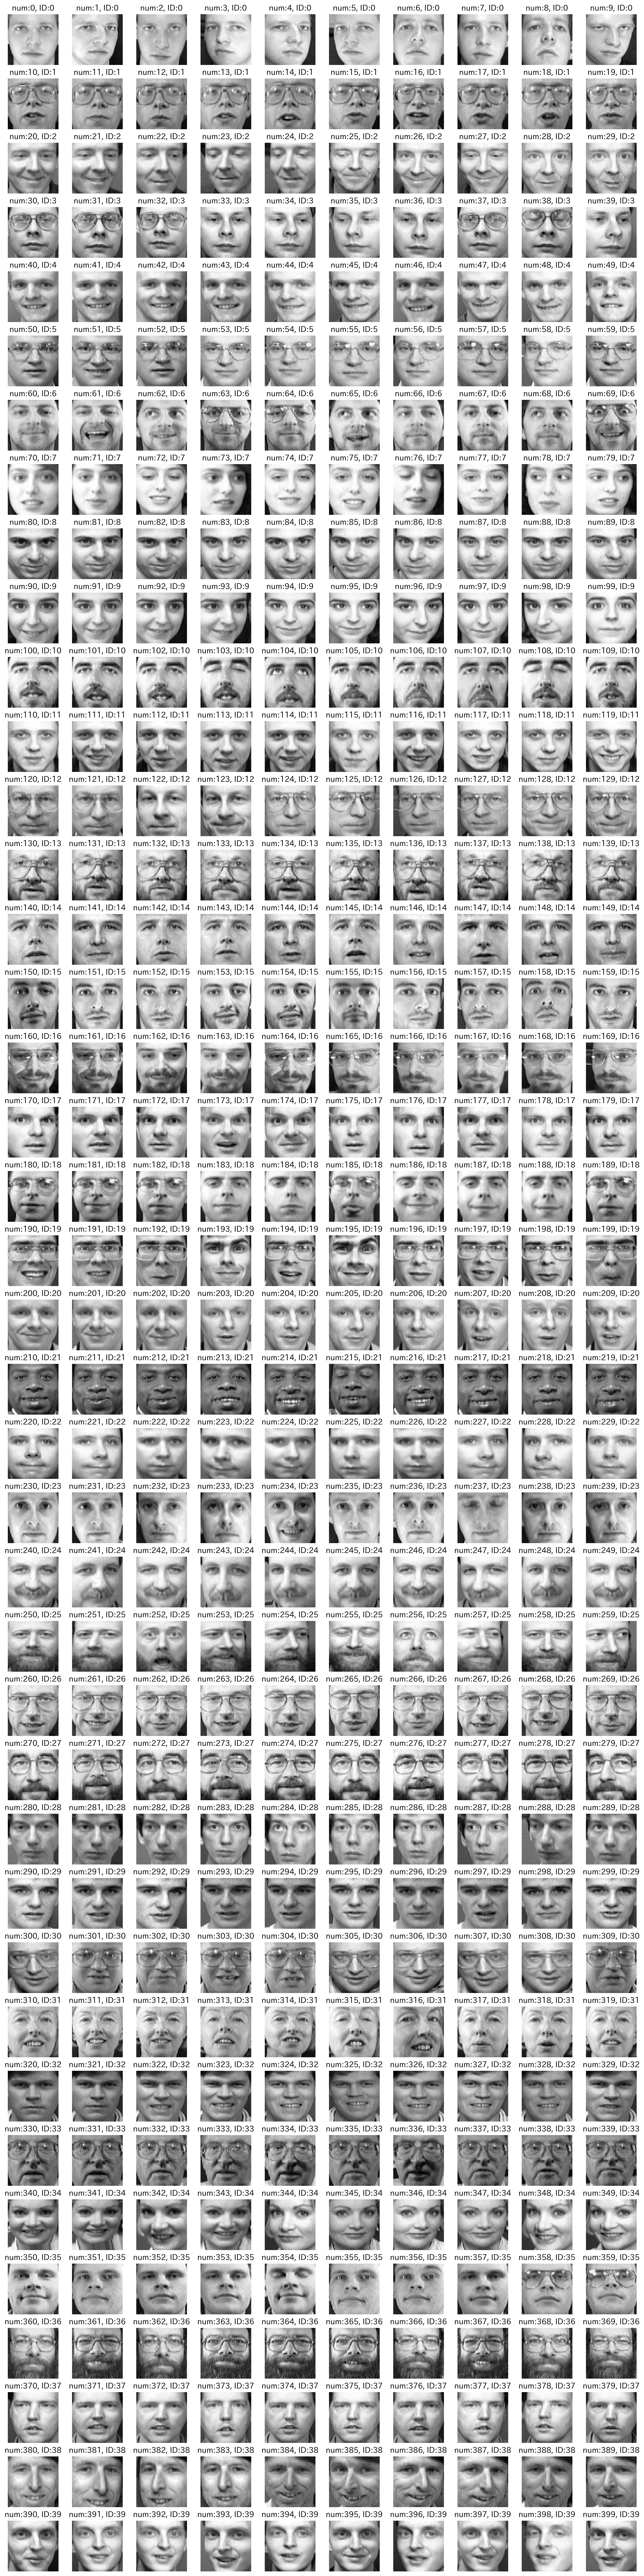

In [ ]:
# データの表示
nrows = 40   # nrows 人分のデータを表示
ncols = 10
fig, fig_axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 1.4, nrows * 1.4), constrained_layout=True)
# constrained_layout は subplot や 凡例やカラーバーなどの装飾を自動的に調整して，
# ユーザが要求する論理的なレイアウトをできるだけ維持しながら， 図ウィンドウに収まるようにします。

for i in range(nrows):
    for j in range(ncols):
        x = i * 10 + j
        fig_axes[i][j].imshow(X[x].reshape(64,64), cmap='gray')
        fig_axes[i][j].axis('off')
        fig_axes[i][j].set_title(f'num:{x}, ID:{y[x]}')

plt.show()

# 機械学習手法による顔認識

## データの分割，訓練データとテストデータ

データを 2 分割して，訓練データセットとテストデータセットに分割します。
分割した訓練データセットでモデルのパラメータを学習し，しかる後に，テストデータセットで，その汎化性能を評価します。
このとき，テストデータセットでの性能が高いモデルが良いモデルということになります。

オリベッティ顔データセットには， 各被験者の 10 枚の顔画像が含まれています。
このうち，例えば 90% を訓練データとし，10% をテストデータとして使用することを考えます。
各顔データの訓練画像とテスト画像の数が同じになるように stratify 機能を使用してます。
したがって，各被験者には 9 枚の訓練用画像と 1 枚のテスト用画像が用意されることになります。
訓練データとテストデータの割合は split_ratio 変更することができます。


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns  # ヒートマップ描画のために使用します

#from sklearn.decomposition import PCA                                # 主成分分析
#from sklearn.svm import SVC                                          # サポートベクターマシン
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # 線形判別分析

# データの分割
# split_ratio = 0.1 としているので，訓練データ対テストデータが 9:1 になる
split_ratio = 0.1
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=split_ratio, stratify=y, random_state=42)
print(f'X_train 訓練画像のサイズ: {X_train.shape}')
print(f'y_train 教師信号データのサイズ: {y_train.shape}')

X_train 訓練画像のサイズ: (360, 4096)
y_train 教師信号データのサイズ: (360,)


## ロジスティック回帰による予測

ロジスティック回帰を用いた分類精度: 80.00%


<Axes: >

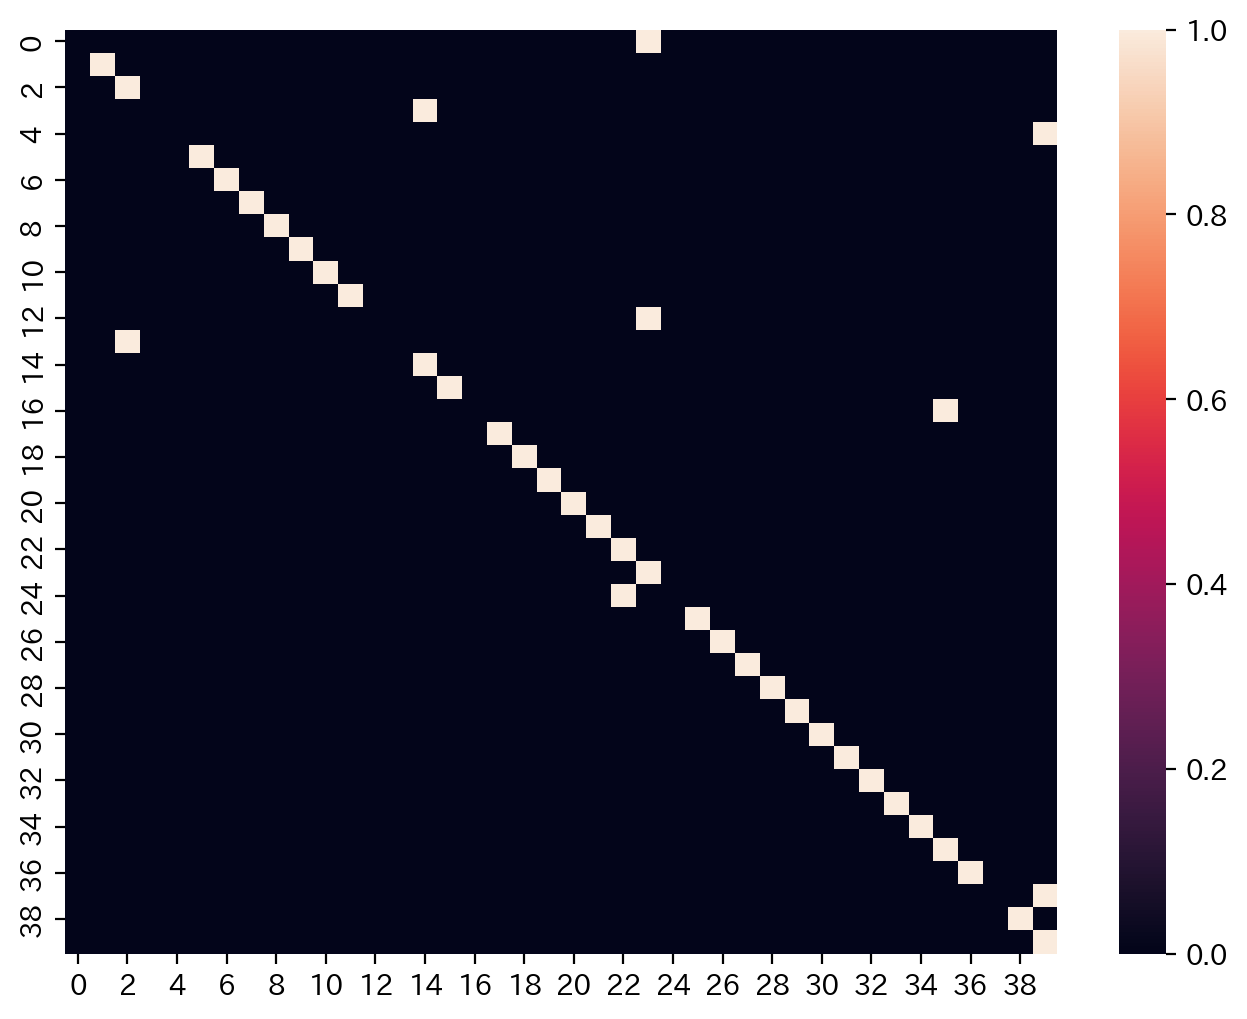

In [ ]:
params = {'max_iter':10 ** 3,
          'C':1e3,
          'penalty':'l2'}

model = LogisticRegression(**params)
model.fit(X_train, y_train)    # 訓練データを用いて線形判別分析モデルを訓練
y_hat = model.predict(X_test)  # テストデータを使って予測を行い結果を y_hat に格納
print(f"ロジスティック回帰を用いた分類精度: {metrics.accuracy_score(y_test, y_hat) * 100:.2f}%")

# 混同行列の表示
plt.figure(figsize=(8,6))
sns.heatmap(metrics.confusion_matrix(y_test, y_hat))

## 交差検証

In [ ]:
%%time
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

name = 'ロジスティック回帰'
model = LogisticRegression(**params)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train, y_train, cv=kfold)
print(f"{name} 平均交差検証得点: {cv_scores.mean():.2f}")

ロジスティック回帰 平均交差検証得点: 0.88
CPU times: user 34.5 s, sys: 2.11 s, total: 36.7 s
Wall time: 3.85 s


## リーブ・ワン・アウト 交差検証

オリベッティ顔データセットには，各被験者に対して 10 枚の顔画像が含まれています。
これは， 機械学習モデルの学習やテストには少ない数です。

クラスの例が少ない機械学習モデルをよりよく評価するために，採用される交差検証法にリーブ・ワン・アウト leave-one-out (LOO) 交差検証法があります。
LOO 法では，あるクラスのサンプルのうち 1 つだけをテストに使用します。
他のサンプルは訓練に使用します。 この手順を， 全サンプルを一度づつテストに使用して繰り返さします。

In [ ]:
%%time
from sklearn.model_selection import LeaveOneOut

loo_cv = LeaveOneOut()
model = LogisticRegression(**params)
cv_scores = cross_val_score(model, X_train, y_train, cv=loo_cv)

print(f"{model.__class__.__name__} リーブ・ワン・アウト交差検証法による平均得点:{cv_scores.mean():.3f}")

## ハイパーパラメータの調整: GridSearcCV

モデルの汎化性能向上のために GridSearchCV を行います。
ロジスティック回帰分類器のハイパーパラメータを調整してみます。

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

params2={'penalty':['l1', 'l2'],
        'C':np.logspace(0, 4, 10),
        'max_iter': [10 ** 4],
       }
model = LogisticRegression()
loo_cv = LeaveOneOut()
gridSearchCV = GridSearchCV(model, params2, cv=loo_cv)
gridSearchCV.fit(X_train, y_train)
print("Grid search fitted..")
print(gridSearchCV.best_params_)
print(gridSearchCV.best_score_)
print(f"グリッドサーチによる交差妥当性得点:{gridSearchCV.score(X_test, y_test):.3f}")

# PCA

## 固有顔 Eigenfaces

与えられた画像表現の問題は、その高次元性である。
2次元の $p\times q$ の濃淡画像は $m=pq$ 次元のベクトル空間にまたがるので、$100\times100$ 画素の画像はすでに 10,000 次元の画像空間にある。
これはどんな計算をするにも多すぎるが、すべての次元が本当に我々にとって有用なのだろうか？
我々はデータに分散がある場合にのみ判断を下すことができるので、我々が探しているのは情報の大部分を占める成分である。
主成分分析 (PCA) は、カール・ピアソン(1901) とハロルド・ホテリング (1933) によって独自に提案されたもので，相関している可能性のある変数の集合を，より小さな相関していない変数の集合に変えるものである。
このアイデアは、高次元のデータ集合は、しばしば相関のある変数によって記述され、したがって、いくつかの意味のある次元だけが情報の大部分を占めるというものである。
PCA は、主成分と呼ばれるデータ中の最大の分散を持つ方向を見つける。
<!-- The problem with the image representation we are given is its high dimensionality.
Two-dimensional pxq grayscale images span a m=pq-dimensional vector space, so an image with 100x100 pixels lies in a 10,000-dimensional image space already.
That's way too much for any computations, but are all dimensions really useful for us?
We can only make a decision if there's any variance in data, so what we are looking for are the components that account for most of the information.
The Principal Component Analysis (PCA) was independently proposed by Karl Pearson (1901) and Harold Hotelling (1933) to turn a set of possibly correlated variables into a smaller set of uncorrelated variables.
The idea is that a high-dimensional dataset is often described by correlated variables and therefore only a few meaningful dimensions account for most of the information.
The PCA method finds the directions with the greatest variance in the data, called principal components. -->


### アルゴリズム<!--Algorithmic Description-->

$X=\left\{x_1,x_2,\ldots,x_n\right\}$ は $x_i\in\mathbb{R}^{d}$ からの確率ベクトルとする:
<!-- Let $X=\left\{x_1,x_2,\ldots,x_n\right\}$ be a random vector with observation $x_i\in\mathbb{R}^{d}$. -->

1. Compute the mean $\mu$
$$\tag{1}
\mu=\frac{1}{n}\sum_{i=1}^{n}x_i.
$$
2. Compute the Covariance matrix $C$
$$\tag{2}
C=\frac{1}{n}\sum_{i=1}^{n}(x_i-\mu)(x_i-\mu)^{\top}.
$$
3. Compute the eigenvalues $\lambda_i$ and eigenvectors $\nu_i$ of $C$
$$\tag{3}
C\nu_i=\lambda_i\nu_i, \text{\hspace{1cm} $i=1,2,\ldots,n$}
$$
4. Order the eigenvalues descending by their eigenvalue.
The $k$ principla components are the eigenvectors corresponding to the $k$ largest eigenvalues.

観測ベクトル $x$ の $k$ 個の主成分は次式で与えられる：<!-- The k principal components of the observed vector $x$ are then given by: -->
$$\tag{4}
y = W^{\top}(x-\mu),
$$
ここで ＄W=\left(v_1,v_2,\ldots,v_k\right)$. <!--where $W=left(v_1,v_2,\ldots,v_k\right)$.-->
PCA 基底からの再構成は次式:<!--The reconstruction from the PCA basis is given by:-->
$$\tag{5}
x= Wy + \mu.
$$
そして固有顔法は、次のようにして顔認識を行う：<!-- The Eigenfaces method then performs face recognition by: -->
1. すべての訓練サンプルを PCA の部分空間に射影する  (式 (4) )。
2. クエリ画像を PCA 部分空間に射影する (リスト 5 を使用)。
3. 投影された訓練サンプルと投影されたクエリ画像の間の最近傍を見つける。

<!-- 1. Projecting all training samples into the PCA subspace (using Equation 4).
2. Projecting the query image into the PCA subspace (using Listing 5).
3. Finding the nearest neighbor between the projected training samples and the projected query image. -->

まだ、解決しなければならない問題が 1 つ残っている。
100x100 画素の画像が 400 枚与えられたとする。
主成分分析（PCA）は共分散行列 $C=XX^{\top}$ を解くが、この例では size(X)=$10000\times400$ である。
結局 10000x10000 の行列になり、ざっと 0.8GB になる。
この問題を解くのは現実的ではないので、トリックを適用する必要がある。
線形代数の授業で、$M>N$ の $M\times N$ 行列は $N-1$ 個の非ゼロ固有値しか持てないことを知っているだろう。
そこで、代わりにサイズ $N\times N$ の固有値分解 $S=X^{\top}X$ を取ることができる：
<!-- Still there is one problem left to solve.
Imagin we are given 400 images sized 100x100 pixels.
The Principal Component Analysis (PCA) solves the covariance matrix $C=XX^{\top}$, where size(X)=10000X400 in our example.
You would end up with a 10000x10000 matrix, rougly 0.8GB.
Solving this  problem is not feasible, so we will need to apply a trick.
From your linear algebra lessons you know that a MxN matrix with M>N can only have N-1 non-zero eigenvalues.
So it is possible to take the eigenvalue decompostion $S=X^{\top}X$ of size NxN instead: -->

In [ ]:
# X を n 行 m 列の行列として，列方向 m x m の相関係数行列を求める
x_bar = np.mean(X, axis=0)         # 各列の平均値を計算
X_bar = X - x_bar                  # 各列の平均値を減じて平均偏差ベクトルとする
Cov = X_bar.T @ X_bar / X.shape[0] # 共分散行列
X_std = np.std(X, axis=0)          # 各列の標準偏差
R = Cov / np.outer(X_std.T, X_std) # 共分散行列の各列を対応する標準偏差の積で除して相関係数行列にする
print(f'R.shape:{R.shape}')        # 確認用 相関係数行列のサイズ
print(f'R\n:{R[:3,:3]}')           # 確認用 相関係数行列の最初の 3 行 3 列を表示する

R2 = np.corrcoef(X.T)              # 上記を一行で行う numpy コマンド
print(f'R2\n:{R2[:3,:3]}')         # 結果の表示


def pca(X, n_dim = 5):
    """N 行 x D 列 の行列の PCA を実施"""
    (n, m) = X.shape  # 行列のサイズを取得
    #X = X - np.tile(np.mean(X, 0), (n, 1))  # X から
    X = X - np.mean(X, axis=0)
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:,0:n_dim])
    return Y

print(pca(X.T)[:3])

R.shape:(4096, 4096)
R
:[[1.0000006  0.9432177  0.814869  ]
 [0.9432177  0.9999998  0.92443025]
 [0.814869   0.92443025 1.0000002 ]]
R2
:[[1.         0.9432174  0.81486848]
 [0.9432174  1.         0.92443031]
 [0.81486848 0.92443031 1.        ]]
[[-2.7122393   2.1089826   0.77511585 -0.65840924 -0.1532129 ]
 [-1.9998534   2.2911568   0.46459845 -0.59731185 -0.16248773]
 [-1.0969465   2.4451728   0.09920794 -0.7813157  -0.07815761]]


In [ ]:
def pca (X, y, num_components=0):
    [n,d] = X. shape
    if ( num_components <= 0) or ( num_components >n):
        num_components = n
    mu = X. mean (axis=0)
    X = X - mu
    if n>d:
        C = np.dot(X.T, X)
        [eigenvalues, eigenvectors] = np.linalg.eigh(C)
    else:
        C = np.dot(X, X.T)
        [eigenvalues, eigenvectors] = np.linalg.eigh(C)
        eigenvectors = np.dot(X.T, eigenvectors)
        for i in range (n):
            eigenvectors[:,i] = eigenvectors[:,i]/ np.linalg.norm(eigenvectors[:,i])

    # or simply perform an economy size decomposition
    # eigenvectors, eigenvalues, variance = np.linalg.svd(X.T, full_matrices=False)
    # sort eigenvectors descending by their eigenvalue
    idx = np.argsort(-eigenvalues)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:,idx]

    # select only num_components
    eigenvalues = eigenvalues[0:num_components].copy()
    eigenvectors = eigenvectors[:,0:num_components].copy()
    return [eigenvalues, eigenvectors, mu]

def project(W, X, mu=None):
     if mu is None :
         return np. dot(X, W)
     return np. dot (X-mu, W)

def reconstruct(W, Y, mu=None):
    if mu is None:
        return np.dot(Y, W.T)
    return np.dot(Y, W.T) + mu

(3,) (4096, 3) (4096,)


IndexError: index 10 is out of bounds for axis 1 with size 3

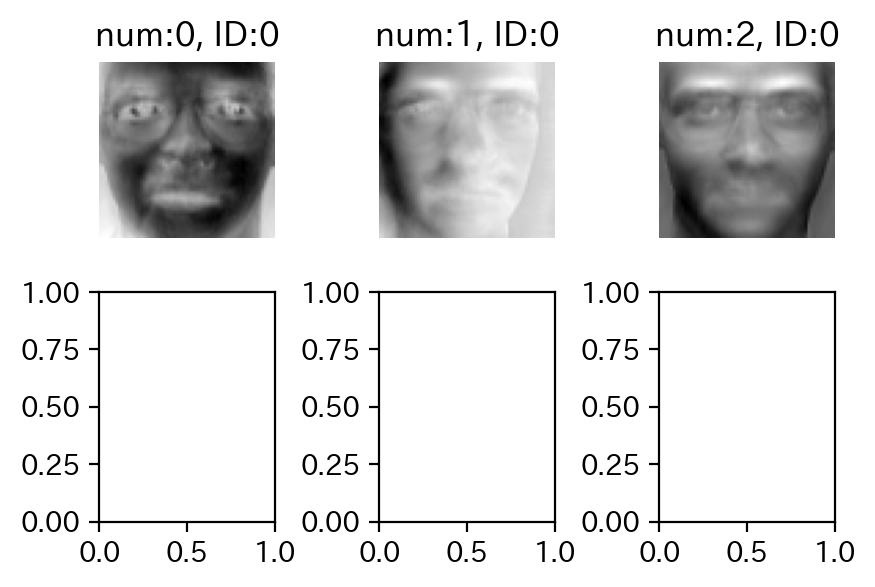

In [ ]:

n_comp = 3
eigs, eigvec, mu = pca(X, y, num_components=n_comp)
print(eigs.shape, eigvec.shape, mu.shape)

# plt.figure(figsize=(2,2))
# plt.imshow((X[0] * eigvec[:,0]+mu[0]).reshape(64,64), cmap='gray')
# plt.show()

# plt.figure(figsize=(2,2))
# plt.imshow((X[0] * eigvec[:,1]+mu[1]).reshape(64,64), cmap='gray')
# plt.show()

# plt.figure(figsize=(2,2))
# plt.imshow((X[0] * eigvec[:,2]+mu[2]).reshape(64,64), cmap='gray')
# plt.show()
# #X[0].shape
# #eigvec[:,0].shape

ncols, nrows = n_comp, 2

fig, fig_axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 1.4, nrows * 1.4), constrained_layout=True)
# constrained_layout は subplot や 凡例やカラーバーなどの装飾を自動的に調整して，
# ユーザが要求する論理的なレイアウトをできるだけ維持しながら， 図ウィンドウに収まるようにします。

for i in range(nrows):
    for j in range(ncols):
        x = i * 10 + j
        fig_axes[i][j].imshow((X[x] * eigvec[:,x]+mu[x]).reshape(64,64), cmap='gray')
        fig_axes[i][j].axis('off')
        fig_axes[i][j].set_title(f'num:{x}, ID:{y[x]}')

plt.show()

In [ ]:
from sklearn.decomposition import PCA
pca_sklearn = PCA(n_components=200)
pca_sklearn.fit(X)
pca_result = pca_sklearn.transform(X)

In [ ]:
#print(pca_result[:10])
print(f'各主成分の寄与率:{pca_sklearn.explained_variance_ratio_[:30]}')  # 各主成分の寄与率
print(f'各主成分の固有値:{pca_sklearn.explained_variance_[:30]}')      # 各主成分の固有値
print(f'主成分ベクトル:{pca_sklearn.components_[:30].shape}')             # 主成分ベクトル
recov = pca_sklearn.inverse_transform(pca_result[:3])  # 主成分を元の次元に戻す
print(recov.shape)


各主成分の寄与率:[0.23812683 0.13993958 0.07968588 0.04998334 0.03609848 0.03156943
 0.02426834 0.02036396 0.01958113 0.01672121 0.01595219 0.0143698
 0.01246738 0.01147132 0.01062877 0.0097772  0.0091906  0.00815573
 0.00753875 0.00746985 0.00698577 0.00614628 0.00583928 0.00569723
 0.00546191 0.00531856 0.00513816 0.00495841 0.00457664 0.00441183]
各主成分の固有値:[18.840141   11.071753    6.304595    3.9545865   2.8560433   2.4977133
  1.9200646   1.6111574   1.549222    1.3229501   1.262107    1.1369108
  0.98639566  0.90758896  0.84092784  0.77355367  0.72714305  0.64526564
  0.5964514   0.5910004   0.5527007   0.48628226  0.46199262  0.45075405
  0.4321357   0.42079422  0.40652168  0.39229998  0.3620953   0.3490559 ]
主成分ベクトル:(30, 4096)
(3, 4096)


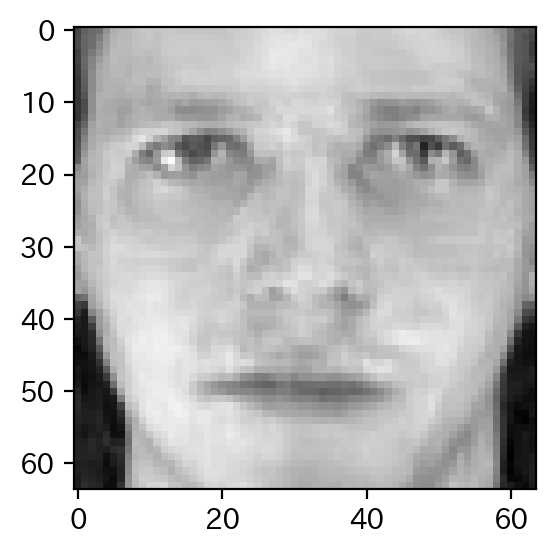

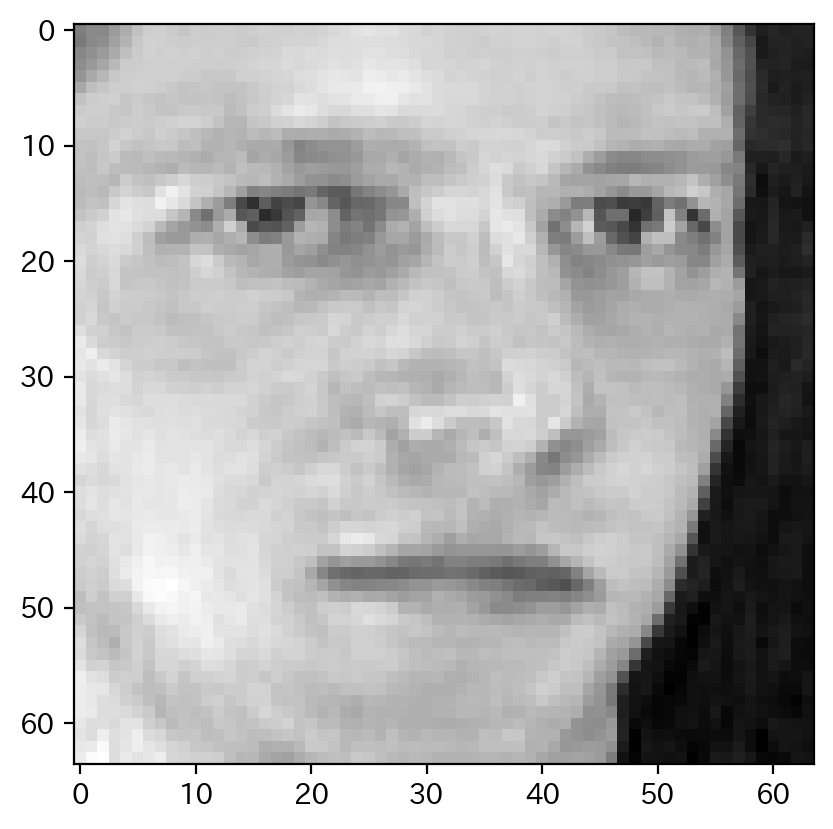

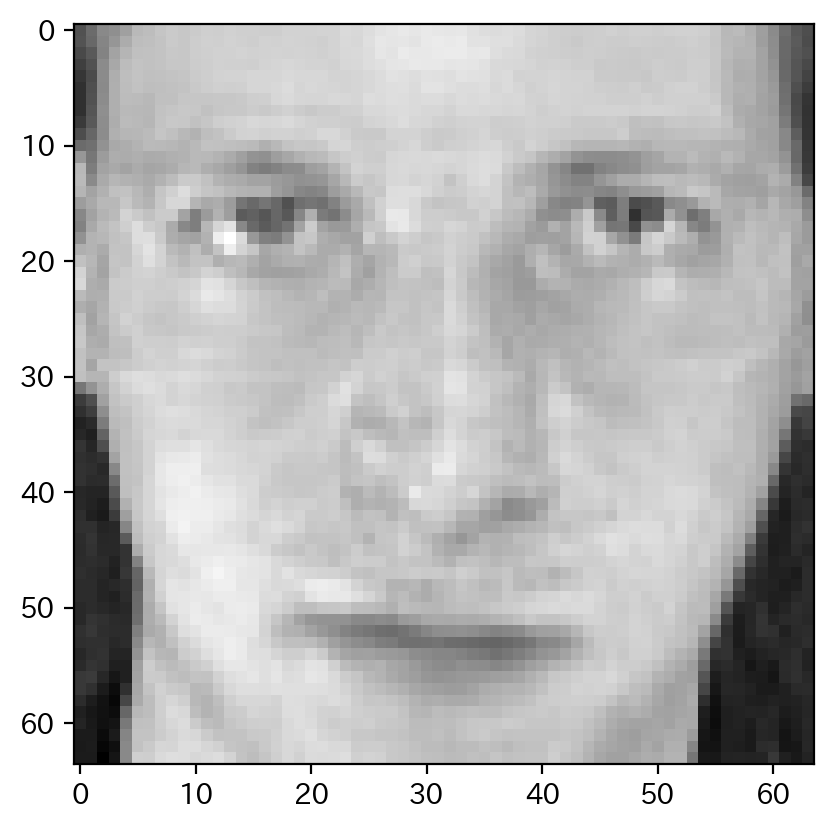

In [ ]:
#print(recov[0].min(),recov[0].max())

plt.figure(figsize=(3, 3))
plt.imshow(recov[0].reshape(64,64), cmap='gray')
plt.show()
plt.imshow(recov[1].reshape(64,64), cmap='gray')
plt.show()
plt.imshow(recov[2].reshape(64,64), cmap='gray')
plt.show()

In [ ]:
#data.data[0].reshape(92,112).shape
4096 / 92

44.52173913043478

## フィッシャー顔 Fisherfaces

線形判別分析は、偉大な統計学者である R.A.フィッシャー 卿によって発明され、彼は1936年の論文 `The use of multiple measurements in classificationonomic problems の中で、アヤメの分類に用いることに成功した。
しかし、主成分分析 (PCA) がこれほどうまくいったのに、なぜ別の次元削減法が必要なのだろうか？
PCA は、データの全分散を最大化する特徴の線形結合を見つける。
これは明らかにデータを表現する強力な方法だが、クラスを考慮しないため、成分を捨てるときに多くの識別情報が失われる可能性がある。
分散が外部ソースによって生成される状況を想像してみよう。
PCA によって同定された成分は、必ずしも識別情報を全く含まないので、投影されたサンプルは互いに混ざり合い、分類は不可能になる。
クラス間を最もよく分離する特徴の組み合わせを見つけるために、線形判別分析はクラス間のばらつきとクラス内のばらつきの比率を最大化する。
考え方は単純で、同じクラスは互いに密に集まり、異なるクラスはできるだけ離れるべきである。
このこと はBelhumeur_Hespanha_Kriegman も認識しており、彼らは [3] で顔認識に判別分析を適用した。
<!-- The Linear Discriminant Analysis was invented by the great statistician Sir R. A. Fisher, who successfully used it for classifying owers in his 1936 paper The use of multiple measurements in taxonomic problems [8].
But why do we need another dimensionality reduction method, if the Principal Component Analysis (PCA) did such a good job?
The PCA  nds a linear combination of features that maximizes the total variance in data.
While this is clearly a powerful way to represuccsent data, it doesn't consider any classes and so a lot of discriminative information may be lost when throwing components away.
Imagine a situation where the variance is generated by an external source, let it be the light.
The components identi ed by a PCA do not necessarily contain any discriminative information at all, so the projected samples are smeared together and a classi cation becomes impossible.
In order to  nd the combination of features that separates best between classes the Linear Discriminant Analysis maximizes the ratio of between-classes to within-classes scatter.
The idea is simple: same classes should cluster tightly together, while di erent classes are as far away as possible from each other.
This was also recognized by Belhumeur, Hespanha and Kriegman and so they applied a Discriminant Analysis to face recognition in [3]. -->

* [3] Belhumeur, P. N., Hespanha, J., and Kriegman, D. Eigenfaces vs.  sherfaces: Recognition using class speci c linear projection. IEEE Transactions on Pattern Analysis and Machine Intelligence 19, 7 (1997), 711-720.
* [4] Brunelli, R., and Poggio, T. Face recognition through geometrical features. In European Conference on Computer Vision (ECCV) (1992), pp. 792-800.
* [5] Cardinaux, F., Sanderson, C., and Bengio, S. User authentication via adapted statistical models of face images. IEEE Transactions on Signal Processing 54 (January 2006), 361-373.
* [6] Chiara Turati, Viola Macchi Cassia, F. S., and Leo, I. Newborns face recognition: Role of inner and outer facial features. Child Development 77, 2 (2006), 297-311.
* [7] Duda, R. O., Hart, P. E., and Stork, D. G. Pattern Classi cation (2nd Edition), 2 ed. November 2001.
* [8] Fisher, R. A. The use of multiple measurements in taxonomic problems. Annals Eugen. 7 (1936), 179-188.

### 2.3.1 アルゴリズムの説明<!-- ### 2.3.1 Algorithmic Description-->

$X$ を $c$ 個のクラスから抽出したランダムベクトルとする：
<!--Let $X$ be a random vector with samples drawn from c classes: -->
$$\tag{8}
X = \left\{X_1,X_2,\ldots,X_{c}\right\}
$$
$$\tag{9}
X_i = \left\{x_1, x_2,\ldots, x_{n}\right\}
$$

分散行列 $S_B$ (級間分散) と $S_W$ (級内分散) は次式のように定義される：
<!-- The scatter matrices $S_B$ and $S_W$ are defined as: -->
$$\tag{10}
S_B = \sum_{i=1}^{c} N_i (\mu_i - \mu)(\mu_i - \mu)^{\top},
$$
$$\tag{11}
S_W = \sum_{i=1}^{c} \sum_{x \in X_i} (x - \mu_i)(x - \mu_i)^{\top},
$$
ここで $\mu$ は全平均:<!--where $\mu$ is the total mean:-->
$$\tag{12}
\mu = \frac{1}{N} \sum_{i=1}^{N} x_i,
$$
さらに $\mu_i$ は群内平均:<!--And $\mu_i$ is the mean of class $i\in\left\{1,\ldots,C\right\}$:-->
$$\tag{13}
\mu_i = \frac{1}{\left|X_i\right|} \sum_{x_{j} \in X_{i}} x_{j}.
$$
フィッシャーの古典的アルゴリズムは、クラス分離可能性基準を最大化する射影行列 $W$ を探す：
<!-- Fisher's classic algorithm now looks for a projection matrix $W$, that maximizes the class separability criterion: -->
$$\tag{14}
W_{opt}=\arg\max_{W} \frac{\left|W^{\top} S_B W\right|}{\left|W^{\top} S_W W\right|},
$$
[3] に従って、この最適化問題の解は、一般固有値問題を解くことによって与えられる：
<!-- Following[3], a solution for this optimization problem is given by solving the Genral Eigenvalue Problem: -->
$$\tag{15}\begin{aligned}
S_{B}\nu_i &= \lambda_i S_{W}\nu_i,\\
S_{W}^{-1} S_{B} \nu_i &= \lambda_i \nu_i,
\end{aligned}$$

解決すべき問題が 1 つ残っている：
$S_W$ のランクは最大でも $(N-c)$ であり，$N$ 個のサンプルと $c$ 個のクラスが存在する。
パターン認識問題では，サンプル数 $N$ は入力データの次元 (画素数) より小さいことがほとんどなので，分散行列 $S_W$ は特異行列になる ([2]を参照)。
[3] では、データに対して主成分分析を実行し、サンプルを (N-c) 次元空間に射影することでこれを解決した。
$S_W$ が特異でなくなったので、線形判別分析が縮小データに対して実行される。
最適化問題は次のように書き換えられる:
<!-- There's one problem left to solve:
The rank of S_W is at most (N-c), with N samples and c classes.
In pattern recognition problems the number of samples N is almost always smaller than the dimension of the input data (the number of pixels), so the scatter matrix SW becomes singular (see [2]).
In [3] this was solved by performing a Principal Component Analysis on the data and projecting the samples int the (N-c)-dimensional space.
A Linear Discriminant Analysis is then performed on the reduced data, becausse S_W is not singular anymore.
The optimization problem is can be rewritten as: -->
$$\tag{16}
W_{pca}=\arg\max_{W} \left|W^{\top} S_T W\right|
$$

$$\tag{17}
W_{fld} = \arg\max_W \frac{\left|W^{\top} W_{pca}^{\top} S_B W_{pca}W\right|}{\left|W^{\top} W_{pca}^{\top}S_W W_{pca}W\right|},
$$
The transformation matrix $W$, that projects a sample into the (c-1)-dimensional space is then given by:
$$\tag{18}
W = W_{fld}^{\top}W_{pca}^{\top}.
$$

最後に注意点：
＄S_W$ と $S_B$ とは対称行列であるが，対称行列同士の積は必ずしも対称ではないので，一般行列用の固有値ソルバを使う必要がある。
OpenCV の `cv:eigen` は，現在のバージョンでは対称行列に対してのみ動作する。
非対称行列に対しては，特異値の固有値は等価ではないので，特異値分解（SVD）ソルバーを利用することはできない．

<!-- one final note:
Although $S_W$ and $S_B$ are symmetric matrices, the product of two symmetric matrices is not necessarily symmetric; thus, so you have to use an eigenvalue solver for general matrices.
OpenCV's `cv:eigen` only works for symmetric matrices in it scurrent version; since eigenvlues of singular values are not equivalent for non-symmetric matrices you can not use a Singular Value Decomposition (SVD) eigher. -->


[https://komazawa-deep-learning.github.io/2023cogpsy/2023cogpsy_lect01](https://komazawa-deep-learning.github.io/2023cogpsy/2023cogpsy_lect01)


[https://komazawa-deep-learning.github.io/2023cogpsy/2023cogpsy_lect01](https://komazawa-deep-learning.github.io/2023cogpsy/2023cogpsy_lect01)